# Computation Photonics Assignment 3: FDTD
## Seminar B Group 1
**Tymoteusz Wrzeszcz, Joshua Jordaan, Yaqi Zhang, Karolina Paciorek**

## Animation and timer functions

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import time

In [2]:
class Fdtd1DAnimation(animation.TimedAnimation):
    '''Animation of the 1D FDTD fields.

    Based on https://matplotlib.org/examples/animation/subplots.html

    Arguments
    ---------
    x : 1d-array
        Spatial coordinates
    t : 1d-array
        Time
    x_interface : float
        Position of the interface (default: None)
    step : float
        Time step between frames (default: 2e-15/25)
    fps : int
        Frames per second (default: 25)
    Ez: 2d-array
        Ez field to animate (each row corresponds to one time step)
    Hy: 2d-array
        Hy field to animate (each row corresponds to one time step)
    '''

    def __init__(self, x, t, Ez, Hy, x_interface=None, step=2e-15/25, fps=25):
        # constants
        c = 2.99792458e8 # speed of light [m/s]
        mu0 = 4*np.pi*1e-7 # vacuum permeability [Vs/(Am)]
        eps0 = 1/(mu0*c**2) # vacuum permittivity [As/(Vm)]
        Z0 = np.sqrt(mu0/eps0) # vacuum impedance [Ohm]
        self.Ez = Ez
        self.Z0Hy = Z0*Hy
        self.x = x
        self.ct = c*t

        # index step between consecutive frames
        self.frame_step = int(round(step/(t[1] - t[0])))

        # set up initial plot
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        vmax = max(np.max(np.abs(Ez)),np.max(np.abs(Hy))*Z0)*1e6
        fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'hspace': 0.4})
        self.line_E, = ax[0].plot(x*1e6, self.E_at_step(0),
                         color=colors[0], label='$\\Re\\{E_z\\}$')
        self.line_H, = ax[1].plot(x*1e6, self.H_at_step(0),
                         color=colors[1], label='$Z_0\\Re\\{H_y\\}$')
        if x_interface is not None:
            for a in ax:
                a.axvline(x_interface*1e6, ls='--', color='k')
        for a in ax:
            a.set_xlim(x[[0,-1]]*1e6)
            a.set_ylim(np.array([-1.1, 1.1])*vmax)
        ax[0].set_ylabel('$\\Re\\{E_z\\}$ [µV/m]')
        ax[1].set_ylabel('$Z_0\\Re\\{H_y\\}$ [µV/m]')
        self.text_E = ax[0].set_title('')
        self.text_H = ax[1].set_title('')
        ax[1].set_xlabel('$x$ [µm]')
        super().__init__(fig, interval=1000/fps, blit=False)

    def E_at_step(self, n):
        return self.Ez[n,:].real*1e6

    def H_at_step(self, n):
        return self.Z0Hy[n,:].real*1e6

    def new_frame_seq(self):
        return iter(range(0, self.ct.size, self.frame_step))

    def _init_draw(self):
        self.line_E.set_ydata(self.x*np.nan)
        self.line_H.set_ydata(self.x*np.nan)
        self.text_E.set_text('')
        self.text_E.set_text('')

    def _draw_frame(self, framedata):
        i = framedata
        self.line_E.set_ydata(self.E_at_step(i))
        self.line_H.set_ydata(self.H_at_step(i))
        self.text_E.set_text(
                'Electric field, $ct = {0:1.2f}$µm'.format(self.ct[i]*1e6))
        self.text_H.set_text(
                'Magnetic field, $ct = {0:1.2f}$µm'.format(self.ct[i]*1e6))
        self._drawn_artists = [self.line_E, self.line_H,
                               self.text_E, self.text_H]


class Fdtd3DAnimation(animation.TimedAnimation):
    '''Animation of a 3D FDTD field.

    Based on https://matplotlib.org/examples/animation/subplots.html

    Arguments
    ---------
    x, y : 1d-array
        Coordinate axes.
    t : 1d-array
        Time
    field: 3d-array
        Slices of the field to animate (the time axis is assumed to be be
        the first axis of the array)
    titlestr : str
        Plot title.
    cb_label : str
        Colrbar label.
    rel_color_range: float
        Range of the colormap relative to the full scale of the field magnitude.
    fps : int
        Frames per second (default: 25)
    '''

    def __init__(self, x, y, t, field, titlestr, cb_label, rel_color_range, fps=25):
        # constants
        c = 2.99792458e8 # speed of light [m/s]
        self.ct = c*t

        self.fig = plt.figure()
        self.F = field
        color_range = rel_color_range*np.max(np.abs(field))
        phw = 0.5*(x[1] - x[0]) # pixel half-width
        extent = ((x[0] - phw)*1e6, (x[-1] + phw)*1e6,
                  (y[-1] + phw)*1e6, (y[0] - phw)*1e6)
        self.mapable = plt.imshow(self.F[0,:,:].real.T,
                                  vmin=-color_range, vmax=color_range,
                                  extent=extent)
        cb = plt.colorbar(self.mapable)
        plt.gca().invert_yaxis()
        self.titlestr = titlestr
        self.text = plt.title('')
        plt.xlabel('x position [µm]')
        plt.ylabel('y position [µm]')
        cb.set_label(cb_label)
        super().__init__(self.fig, interval=1000/fps, blit=False)

    def new_frame_seq(self):
        return iter(range(self.ct.size))

    def _init_draw(self):
        self.mapable.set_array(np.nan*self.F[0, :, :].real.T)
        self.text.set_text('')

    def _draw_frame(self, framedata):
        i = framedata
        self.mapable.set_array(self.F[i, :, :].real.T)
        self.text.set_text(self.titlestr
                           + ', $ct$ = {0:1.2f}µm'.format(self.ct[i]*1e6))
        self._drawn_artists = [self.mapable, self.text]


class Timer(object):
    '''Tic-toc timer.
    '''
    def __init__(self):
        '''Initializer.
        Stores the current time.
        '''
        self._tic = time.time()

    def tic(self):
        '''Stores the current time.
        '''
        self._tic = time.time()

    def toc(self):
        '''Returns the time in seconds that has elapsed since the last call
        to tic().
        '''
        return time.time() - self._tic

## FDTD method implementation
### 1D

In [3]:
def fdtd_1d(eps_rel, dx, time_span, source_frequency, source_position, source_pulse_length):
    '''Computes the temporal evolution of a pulsed excitation using the
    1D FDTD method. The temporal center of the pulse is placed at a
    simulation time of 3*source_pulse_length. The origin x=0 is in the
    center of the computational domain. All quantities have to be
    specified in SI units.

    Arguments
    ---------
        eps_rel : 1d-array
            Rel. permittivity distribution within the computational domain.
        dx : float
            Spacing of the simulation grid (please ensure dx <= lambda/20).
        time_span : float
            Time span of simulation.
        source_frequency : float
            Frequency of current source.
        source_position : float
            Spatial position of current source.
        source_pulse_length :
            Temporal width of Gaussian envelope of the source.

    Returns
    -------
        Ez : 2d-array
            Z-component of E(x,t) (each row corresponds to one time step)
        Hy : 2d-array
            Y-component of H(x,t) (each row corresponds to one time step)
        x  : 1d-array
            Spatial coordinates of the field output
        t  : 1d-array
            Time of the field output
    '''
    Nx = int(round(x_span/dx)) + 1
    x = np.linspace(-x_span/2, x_span/2, Nx)
    dt = dx / (2 * c)
    t = np.arange(0, time_span, dt)
    # delta distribution
    j_spat = np.zeros(Nx)
    j_spat[Nx // 2 + int(source_position / dx)] = 1
    # temporal part of the excitation
    time_part = np.exp(2 * np.pi * source_frequency * t / complex(0, 1)) * np.exp(-(t - 3 * source_pulse_length)**2 / (source_pulse_length**2))
    Ez = np.empty((len(t), Nx), dtype = 'complex')
    Hy = np.empty((len(t), Nx), dtype = 'complex')
    Ez[0, :] = 0
    Hy[0, :] = 0    
    n = 0
    while (n < len(t) - 1):
        Ez[n+1, 1:Nx] = Ez[n, 1:Nx] + (dt / (eps0 * eps_rel[1:Nx] * dx)) * (Hy[n, 1:Nx] - Hy[n, 0:Nx-1]) - ((dt * j_spat[1:Nx] * time_part[n]) / (eps0 * eps_rel[1:Nx]))
        Ez[n+1, 0] = Ez[n, 0] + (dt / (eps0 * eps_rel[0] * dx)) * Hy[n, 0] - ((dt * j_spat[0] * time_part[n]) / (eps0 * eps_rel[0]))
        Hy[n+1, 0:Nx-1] = Hy[n, 0:Nx-1] + (dt / (mu0 * dx)) * (Ez[n+1, 1:Nx] - Ez[n+1, 0:Nx-1])
        Hy[n+1, -1] = Hy[n, -1] + (dt / (mu0 * dx)) *  (-Ez[n+1, -1])
        n+=1  
    return Ez, Hy, x, t   
    pass


## Test results 

### 1D

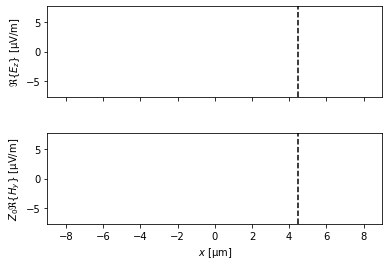

Text(0.5, 1.0, 't = 3.75259607097921 $fs$')

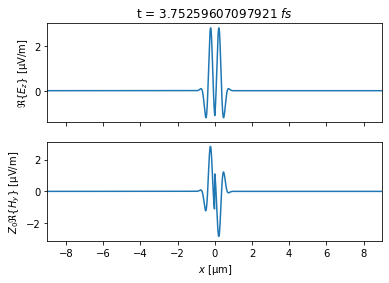

In [5]:
import numpy as np
from matplotlib import pyplot as plt


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# constants
c = 2.99792458e8 # speed of light [m/s]
mu0 = 4*np.pi*1e-7 # vacuum permeability [Vs/(Am)]
eps0 = 1/(mu0*c**2) # vacuum permittivity [As/(Vm)]
Z0 = np.sqrt(mu0/eps0) # vacuum impedance [Ohm]

# geometry parameters
x_span = 18e-6 # width of computatinal domain [m]
n1 = 1 # refractive index in front of interface
n2 = 2 # refractive index behind interface
x_interface = x_span/4 #postion of dielectric interface

# simulation parameters
dx = 15e-9 # grid spacing [m]
time_span = 60e-15 # duration of simulation [s]

Nx = int(round(x_span/dx)) + 1 # number of grid points

# source parameters
source_frequency = 500e12 # [Hz]
source_position = 0 # [m]
source_pulse_length = 1e-15 # [s]

# %% create permittivity distribution and run simulation %%%%%%%%%%%%%%%%%%%%%%

x = np.linspace(-x_span/2, x_span/2, Nx)
eps_rel = np.empty(Nx)
eps_rel[x < x_interface] = n1**2
eps_rel[x >= x_interface] = n2**2
Ez, Hy, x, t = fdtd_1d(eps_rel, dx, time_span, source_frequency, source_position, source_pulse_length)
# %% make video %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
fps = 25
step = t[-1]/fps/30
ani = Fdtd1DAnimation(x, t, Ez, Hy, x_interface=x_interface,
                       step=step, fps=fps)
plt.show()

# %% create representative figures of the results %%%%%%%%%%%%%%%%%%%%%%%%%%%%%

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(x*1e6, 1e6 * Ez[150, :].real, label = "$\\Re\\{E_z\\}$")
ax[1].plot(x*1e6, 1e6 * Z0 * Hy[150, :].real, label = "Z_0\\Re\\{H_y\\}")
ax[0].set_ylabel('$\\Re\\{E_z\\}$ [µV/m]')
ax[1].set_ylabel('$Z_0\\Re\\{H_y\\}$ [µV/m]')
ax[1].set_xlabel('$x$ [µm]')
ax[0].set_xlim(x[[0,-1]]*1e6)
ax[1].set_xlim(x[[0,-1]]*1e6)
ax[0].set_title('t = ' + str(t[150] * 1e15) + ' ' + '$fs$')

## Convergence and accuracy tests

### 1D

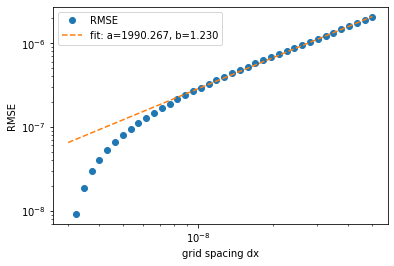

In [24]:
def f(x, a, b):
    return a * x**b

dxx = np.logspace(np.log10(3e-9), np.log10(50e-9), 40)

# dx interpolation

# field at last time step taken for every dx and interpolated to grid 
# that corresponds to the lowest dx - reference
# RMSE is calculated with lowest dx as a reference

# grid = np.linspace(-x_span/2, x_span/2, int(round(x_span/dxx[0])) + 1)
# last_step = np.empty((len(dxx), int(round(x_span/dxx[0])) + 1))
# rmse = []
# i = 0

# for item in dxx:
#       x = np.linspace(-x_span/2, x_span/2, int(round(x_span/item)) + 1)
#       eps_rel = np.empty(int(round(x_span/item)) + 1)
#       eps_rel[x < x_interface] = n1**2
#       eps_rel[x >= x_interface] = n2**2
#       Ez, Hy, x, t = fdtd_1d(eps_rel, item, time_span, source_frequency, source_position, source_pulse_length)
#       if (item > dxx[0]):
#           v_out_int = griddata(x, abs(Ez[-1, :]), grid, method='nearest')
#           last_step[i, :] = abs(v_out_int)
#       else:
#           last_step[i, :] = abs(Ez[-1, :])
#       rmse = np.append(rmse, np.sqrt(sum((last_step[i, :] - last_step[0, :])**2)/(int(round(x_span/dxx[0])) + 1)))
#       i+=1

# popt, pcov = curve_fit(f, dxx, rmse)


# fig = plt.figure()
# plt.plot(dxx, rmse, 'o', label = 'RMSE')
# plt.plot(dxx, f(dxx, *popt), '--', label = 'fit: a=%5.3f, b=%5.3f' % tuple(popt))
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('grid spacing dx')
# plt.ylabel('RMSE')
# plt.legend()


# dt interpolation

# same parameters as for upper case 
# central point of field distribution for every time step taken
# and interpolated in time with grid that corresponds to lowest dt
# RMSE is calculated with lowest dt as a reference

dtt = dxx[0] / (2 * c)
grid = np.arange(0, time_span, dtt)
mid_points = np.empty((len(grid), len(dxx)))
rmse = []
i = 0

for item in dxx:
      Nxx = int(round(x_span/item)) + 1
      x = np.linspace(-x_span/2, x_span/2, int(round(x_span/item)) + 1)
      eps_rel = np.empty(int(round(x_span/item)) + 1)
      eps_rel[x < x_interface] = n1**2
      eps_rel[x >= x_interface] = n2**2
      Ez, Hy, x, t = fdtd_1d(eps_rel, item, time_span, source_frequency, source_position, source_pulse_length)
      if (item > dxx[0]):
          v_out_int = griddata(t, abs(Ez[:, Nxx // 2]), grid, method='nearest')
          mid_points[:, i] = abs(v_out_int)
      else:
          mid_points[:, i] = abs(Ez[:, Nxx // 2])
      rmse = np.append(rmse, np.sqrt(sum((mid_points[:, i] - mid_points[:, 0])**2)/(int(round(x_span/dxx[0])) + 1)))
      i+=1


popt, pcov = curve_fit(f, dxx, rmse)


fig = plt.figure()
plt.plot(dxx, rmse, 'o', label = 'RMSE')
plt.plot(dxx, f(dxx, *popt), '--', label = 'fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('grid spacing dx')
plt.ylabel('RMSE')
plt.legend()


### 3D

In [11]:
def fdtd_3d(eps_rel, dr, time_span, freq, tau, jx, jy, jz,
            field_component, z_ind, output_step):
    '''Computes the temporal evolution of a pulsed spatially extended current
    source using the 3D FDTD method. Returns z-slices of the selected
    field at the given z-position every output_step time steps. The pulse
    is centered at a simulation time of 3*tau. All quantities have to be
    specified in SI units.

    Arguments
    ---------
        eps_rel: 3d-array
            Rel. permittivity distribution within the computational domain.
        dr: float
            Grid spacing (please ensure dr<=lambda/20).
        time_span: float
            Time span of simulation.
        freq: float
            Center frequency of the current source.
        tau: float
            Temporal width of Gaussian envelope of the source.
        jx, jy, jz: 3d-array
            Spatial density profile of the current source.
        field_component : str
            Field component which is stored (one of ‘ex’,’ey’,’ez’,
            ’hx’,’hy’,’hz’).
        z_index: int
            Z-position of the field output.
        output_step: int
            Number of time steps between field outputs.

    Returns
    -------
        F: 3d-array
            Z-slices of the selected field component at the
            z-position specified by z_ind stored every output_step
            time steps (time varies along the first axis).
        t: 1d-array
            Time of the field output.
    '''
    pass


### 3D

### 3D

In [ ]:
'''Test script for Homework 3, Computational Photonics, SS 2020:  FDTD method.
'''


import numpy as np
from Homework_3_function_headers import fdtd_3d, Fdtd3DAnimation
from matplotlib import pyplot as plt

# dark bluered colormap, registers automatically with matplotlib on import
import bluered_dark


plt.rcParams.update({
        'figure.figsize': (12/2.54, 9/2.54),
        'figure.subplot.bottom': 0.15,
        'figure.subplot.left': 0.165,
        'figure.subplot.right': 0.90,
        'figure.subplot.top': 0.9,
        'axes.grid': False,
        'image.cmap': 'bluered_dark',
})

plt.close('all')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# constants
c = 2.99792458e8 # speed of light [m/s]
mu0 = 4*np.pi*1e-7 # vacuum permeability [Vs/(Am)]
eps0 = 1/(mu0*c**2) # vacuum permittivity [As/(Vm)]
Z0 = np.sqrt(mu0/eps0) # vacuum impedance [Ohm]

# simulation parameters
Nx = 199 # nuber of grid points in x-direction
Ny = 201 # nuber of grid points in y-direction
Nz = 5   # nuber of grid points in z-direction
dr = 30e-9 # grid spacing in [m]
time_span = 10e-15 # duration of simulation [s]

# x coordinates
x = np.arange(-int(np.ceil((Nx-1)/2)), int(np.floor((Nx-1)/2)) + 1)*dr
# y coordinates
y = np.arange(-int(np.ceil((Ny-1)/2)), int(np.floor((Ny-1)/2)) + 1)*dr

# source parameters
freq = 500e12 # pulse [Hz]
tau = 1e-15 # pulse width [s]
source_width = 2 # width of Gaussian current dist. [grid points]

# grid midpoints
midx = int(np.ceil((Nx-1)/2))
midy = int(np.ceil((Ny-1)/2))
midz = int(np.ceil((Nz-1)/2))


# %% create relative permittivity distribution %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# eps_rel = ...

# %% current distributions %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# jx = jy = np.zeros(...) 
# jz : Gaussion distribution in the xy-plane with a width of 2 grid points, 
# constant along z

# jx = ...
# jy = ...
# jz = ...

# output parameters
z_ind = midz # z-index of field output
output_step = 4 # time steps between field output

#%% run simulations %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# please add your code here

#%% movie of Hx %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
F = Hx*Z0*1e6
titlestr = 'x-Component of Magnetic Field'
cb_label = '$\\Re\\{Z_0H_x\\}$ [µV/m]'
rel_color_range = 1/3
fps = 10

ani = Fdtd3DAnimation(x, y, t, F, titlestr, cb_label, rel_color_range, fps)
plt.show()

#%% movie of Ez %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
F = Ez*1e6
titlestr = 'z-Component of Electric Field'
cb_label = '$\\Re\\{E_z\\}$ [µV/m]'
rel_color_range = 1/3
fps = 10

ani = Fdtd3DAnimation(x, y, t, F, titlestr, cb_label, rel_color_range, fps)
plt.show()

# %% create representative figures of the results %%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# please add your code here


## Investigation of parameter changes